In [1]:
import requests
import pandas as pd
import time
import os
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import sqlite3
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import matplotlib.pyplot as plt


In [2]:
def simulate_historical_data(conn, cursor, cities_to_simulate, num_days=30):
    """
    Symuluje dane historyczne dla podanych miast i ładuje je do tabeli METEO.
    Generuje dane dla ostatnich 'num_days' dni, co godzinę.
    """
    print(f"Simulating historical data for {cities_to_simulate} for {num_days} days...")
    
    station_ids = {}
    for city_name in cities_to_simulate:
        cursor.execute("SELECT Station_Id FROM STATIONS WHERE station_name = ?", (city_name,))
        result = cursor.fetchone()
        if result:
            station_ids[city_name] = result[0]
        else:
            temp_id = hash(city_name) % 100000
            cursor.execute("INSERT OR IGNORE INTO STATIONS (Station_Id, station_name) VALUES (?, ?)", (temp_id, city_name))
            conn.commit()
            station_ids[city_name] = temp_id
            print(f"Added placeholder station ID {temp_id} for {city_name} to STATIONS.")


    today = datetime.now()
    all_simulated_data = []

    for i in range(num_days, 0, -1): 
        current_date = today - timedelta(days=i)
        for hour in range(24):
            for city_name, station_id in station_ids.items():
                temp_base = 15 + np.sin(current_date.day / 30 * 2 * np.pi) * 10 + np.sin(hour / 24 * 2 * np.pi) * 5
                wind_base = 5 + np.random.rand() * 5
                humidity_base = 70 + np.random.rand() * 20
                pressure_base = 1010 + np.random.rand() * 10
                precip_base = np.random.choice([0, 0.1, 0.5, 1], p=[0.8, 0.1, 0.05, 0.05]) # Często 0

                simulated_row = {
                    'id_stacji': station_id,
                    'stacja': city_name,
                    'data_pomiaru': current_date.strftime('%Y-%m-%d'),
                    'godzina_pomiaru': hour,
                    'temperatura': round(temp_base + np.random.randn() * 2, 2),
                    'predkosc_wiatru': round(wind_base + np.random.randn() * 1, 2),
                    'kierunek_wiatru': np.random.randint(0, 360),
                    'wilgotnosc_wzgledna': round(humidity_base + np.random.randn() * 5, 2),
                    'suma_opadu': round(max(0, precip_base + np.random.randn() * 0.1), 2),
                    'cisnienie': round(pressure_base + np.random.randn() * 2, 2)
                }
                all_simulated_data.append(simulated_row)
    
    df_simulated = pd.DataFrame(all_simulated_data)
    load_data(df_simulated, 'METEO', conn)
    print("Historical data simulation complete.")


def fetch_city_data(conn, city_name: str):
    """Pobiera wszystkie historyczne dane dla danej stacji z bazy METEO."""
    query = """
    SELECT 
        m.Date, 
        m.Hour, 
        m.Temperature, 
        m.Wind_Speed, 
        m.Wind_Direction, 
        m.Relative_Humidity, 
        m.Precipitation_Total, 
        m.Pressure
    FROM METEO m
    JOIN STATIONS s ON m.Station_Id = s.Station_Id
    WHERE s.station_name = ?
    ORDER BY m.Date ASC, m.Hour ASC
    """
    df = pd.read_sql_query(query, conn, params=(city_name,))
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Hour'].astype(str) + ':00:00')
    df = df.set_index('datetime').sort_index()
    return df

def prepare_forecast_data(df: pd.DataFrame, target_columns: list, lags: list):
    """
    Przygotowuje dane historyczne do prognozowania, tworząc cechy czasowe i opóźnione.
    """
    df = df[~df.index.duplicated(keep='first')]

    if not df.empty:
        full_time_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
        df = df.reindex(full_time_range)
    else:
        print("Ostrzeżenie: Pusty DataFrame w prepare_forecast_data. Nie można utworzyć cech.")
        return pd.DataFrame()

    df['hour_of_day'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['month'] = df.index.month

    for col in target_columns:
        for lag in lags:
            df[f'{col}_lag_{lag}h'] = df[col].shift(lag)
    
    df_prepared = df.dropna()

    if df_prepared.empty:
        print("Ostrzeżenie: DataFrame jest pusty po usunięciu NaN. Sprawdź zakres danych historycznych i długość lagów.")
    return df_prepared

def train_and_forecast_city(df_historical: pd.DataFrame, forecast_hours: int = 72):
    """
    Trenuje model RandomForestRegressor dla każdego parametru i prognozuje na określoną liczbę godzin.
    """
    if df_historical.empty:
        print("Brak danych historycznych do prognozowania.")
        return pd.DataFrame()

    target_columns = ['Temperature', 'Wind_Speed', 'Relative_Humidity', 'Pressure']
    
    feature_columns = [col for col in df_historical.columns if '_lag_' in col or col in ['hour_of_day', 'day_of_week', 'day_of_year', 'month']]
    
    if not feature_columns:
        print("Brak kolumn cech do trenowania modelu. Sprawdź funkcję prepare_forecast_data.")
        return pd.DataFrame()

    models = {}
    for target in target_columns:
        X = df_historical[feature_columns]
        y = df_historical[target]
        
        valid_indices = y.dropna().index
        X_clean = X.loc[valid_indices]
        y_clean = y.loc[valid_indices]

        if X_clean.empty:
            print(f"Brak danych do trenowania modelu dla {target}.")
            continue

        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        model.fit(X_clean, y_clean)
        models[target] = model
    
    if not models:
        print("Nie udało się wytrenować żadnych modeli.")
        return pd.DataFrame()

    last_known_data = df_historical.iloc[-1].copy()
    forecast_records = []
    
    current_time = last_known_data.name 

    for i in range(1, forecast_hours + 1):
        next_time = current_time + timedelta(hours=1)
        
        
        next_features = pd.Series(index=feature_columns, dtype=float)
        
        next_features['hour_of_day'] = next_time.hour
        next_features['day_of_week'] = next_time.dayofweek
        next_features['day_of_year'] = next_time.dayofyear
        next_features['month'] = next_time.month

        for col in target_columns:
            for lag in [1, 2, 3, 24, 48, 72]: 
                lag_col_name = f'{col}_lag_{lag}h'
                if lag_col_name in feature_columns:
                  
                    current_values = {col: last_known_data[col] for col in target_columns}

                    temp_features = pd.Series(index=feature_columns, dtype=float)
                    
                    temp_features['hour_of_day'] = next_time.hour
                    temp_features['day_of_week'] = next_time.dayofweek
                    temp_features['day_of_year'] = next_time.dayofyear
                    temp_features['month'] = next_time.month

                    
                    current_state_df = df_historical.iloc[-max_lag:].copy()
                    
                    current_state_df.loc[next_time] = np.nan
                    

                    current_forecast_values = {} 
                    
                    for target in target_columns:
                
                        X_pred_dict = {}
                        X_pred_dict['hour_of_day'] = next_time.hour
                        X_pred_dict['day_of_week'] = next_time.dayofweek
                        X_pred_dict['day_of_year'] = next_time.dayofyear
                        X_pred_dict['month'] = next_time.month
                        
                        for lag in [1, 2, 3, 24, 48, 72]:
                            lag_col_name = f'{target}_lag_{lag}h'
                        
                            lag_time = next_time - timedelta(hours=lag)
                            
                            if lag_time in current_state_df.index:
                               
                                X_pred_dict[lag_col_name] = current_state_df.loc[lag_time, target]
                            else:
                                X_pred_dict[lag_col_name] = np.nan 
                    
                        X_pred = pd.DataFrame([X_pred_dict], columns=feature_columns)
                        
              
                        if target in models and not X_pred.isnull().any().any(): 
                            predicted_value = models[target].predict(X_pred)[0]
                            current_forecast_values[target] = predicted_value
                        else:
                            current_forecast_values[target] = np.nan 
                            print(f"Warning: Could not predict {target} for {next_time} due to missing model or NaN features.")

                    forecast_records.append({
                        'Date': next_time.strftime('%Y-%m-%d'),
                        'Hour': next_time.hour,
                        **current_forecast_values
                    })
                    
               
                    new_row = pd.Series(current_forecast_values, index=target_columns, name=next_time)
                    current_state_df = pd.concat([current_state_df, pd.DataFrame([new_row])])
                    current_state_df = current_state_df.iloc[1:] 
                    
                    current_time = next_time 

    df_forecast = pd.DataFrame(forecast_records)
    return df_forecast

Removed existing data.db
Simulating historical data for ['Kraków', 'Warszawa', 'Gdańsk'] for 30 days...
Dane załadowane do tabeli METEO.
Historical data simulation complete.

--- Rozpoczynanie prognozowania ---

Generowanie prognozy dla: Kraków

Prognoza pogody dla Kraków na najbliższe 3 dni:
         Date  Hour  Temperature  Wind_Speed  Relative_Humidity   Pressure  \
0  2025-06-13     0      21.1896      7.9508            81.1214  1014.9841   
1  2025-06-13     1      21.3051      6.9983            81.5041  1016.1560   
2  2025-06-13     2      23.8305      7.4564            79.5129  1015.3717   
3  2025-06-13     3      23.2891      7.1529            82.1899  1015.0801   
4  2025-06-13     4      23.8994      7.2775            81.2540  1015.1341   

   Precipitation_Total  
0               0.2483  
1               0.0506  
2               0.0831  
3               0.0536  
4               0.0472  
...
          Date  Hour  Temperature  Wind_Speed  Relative_Humidity   Pressure  \
67  

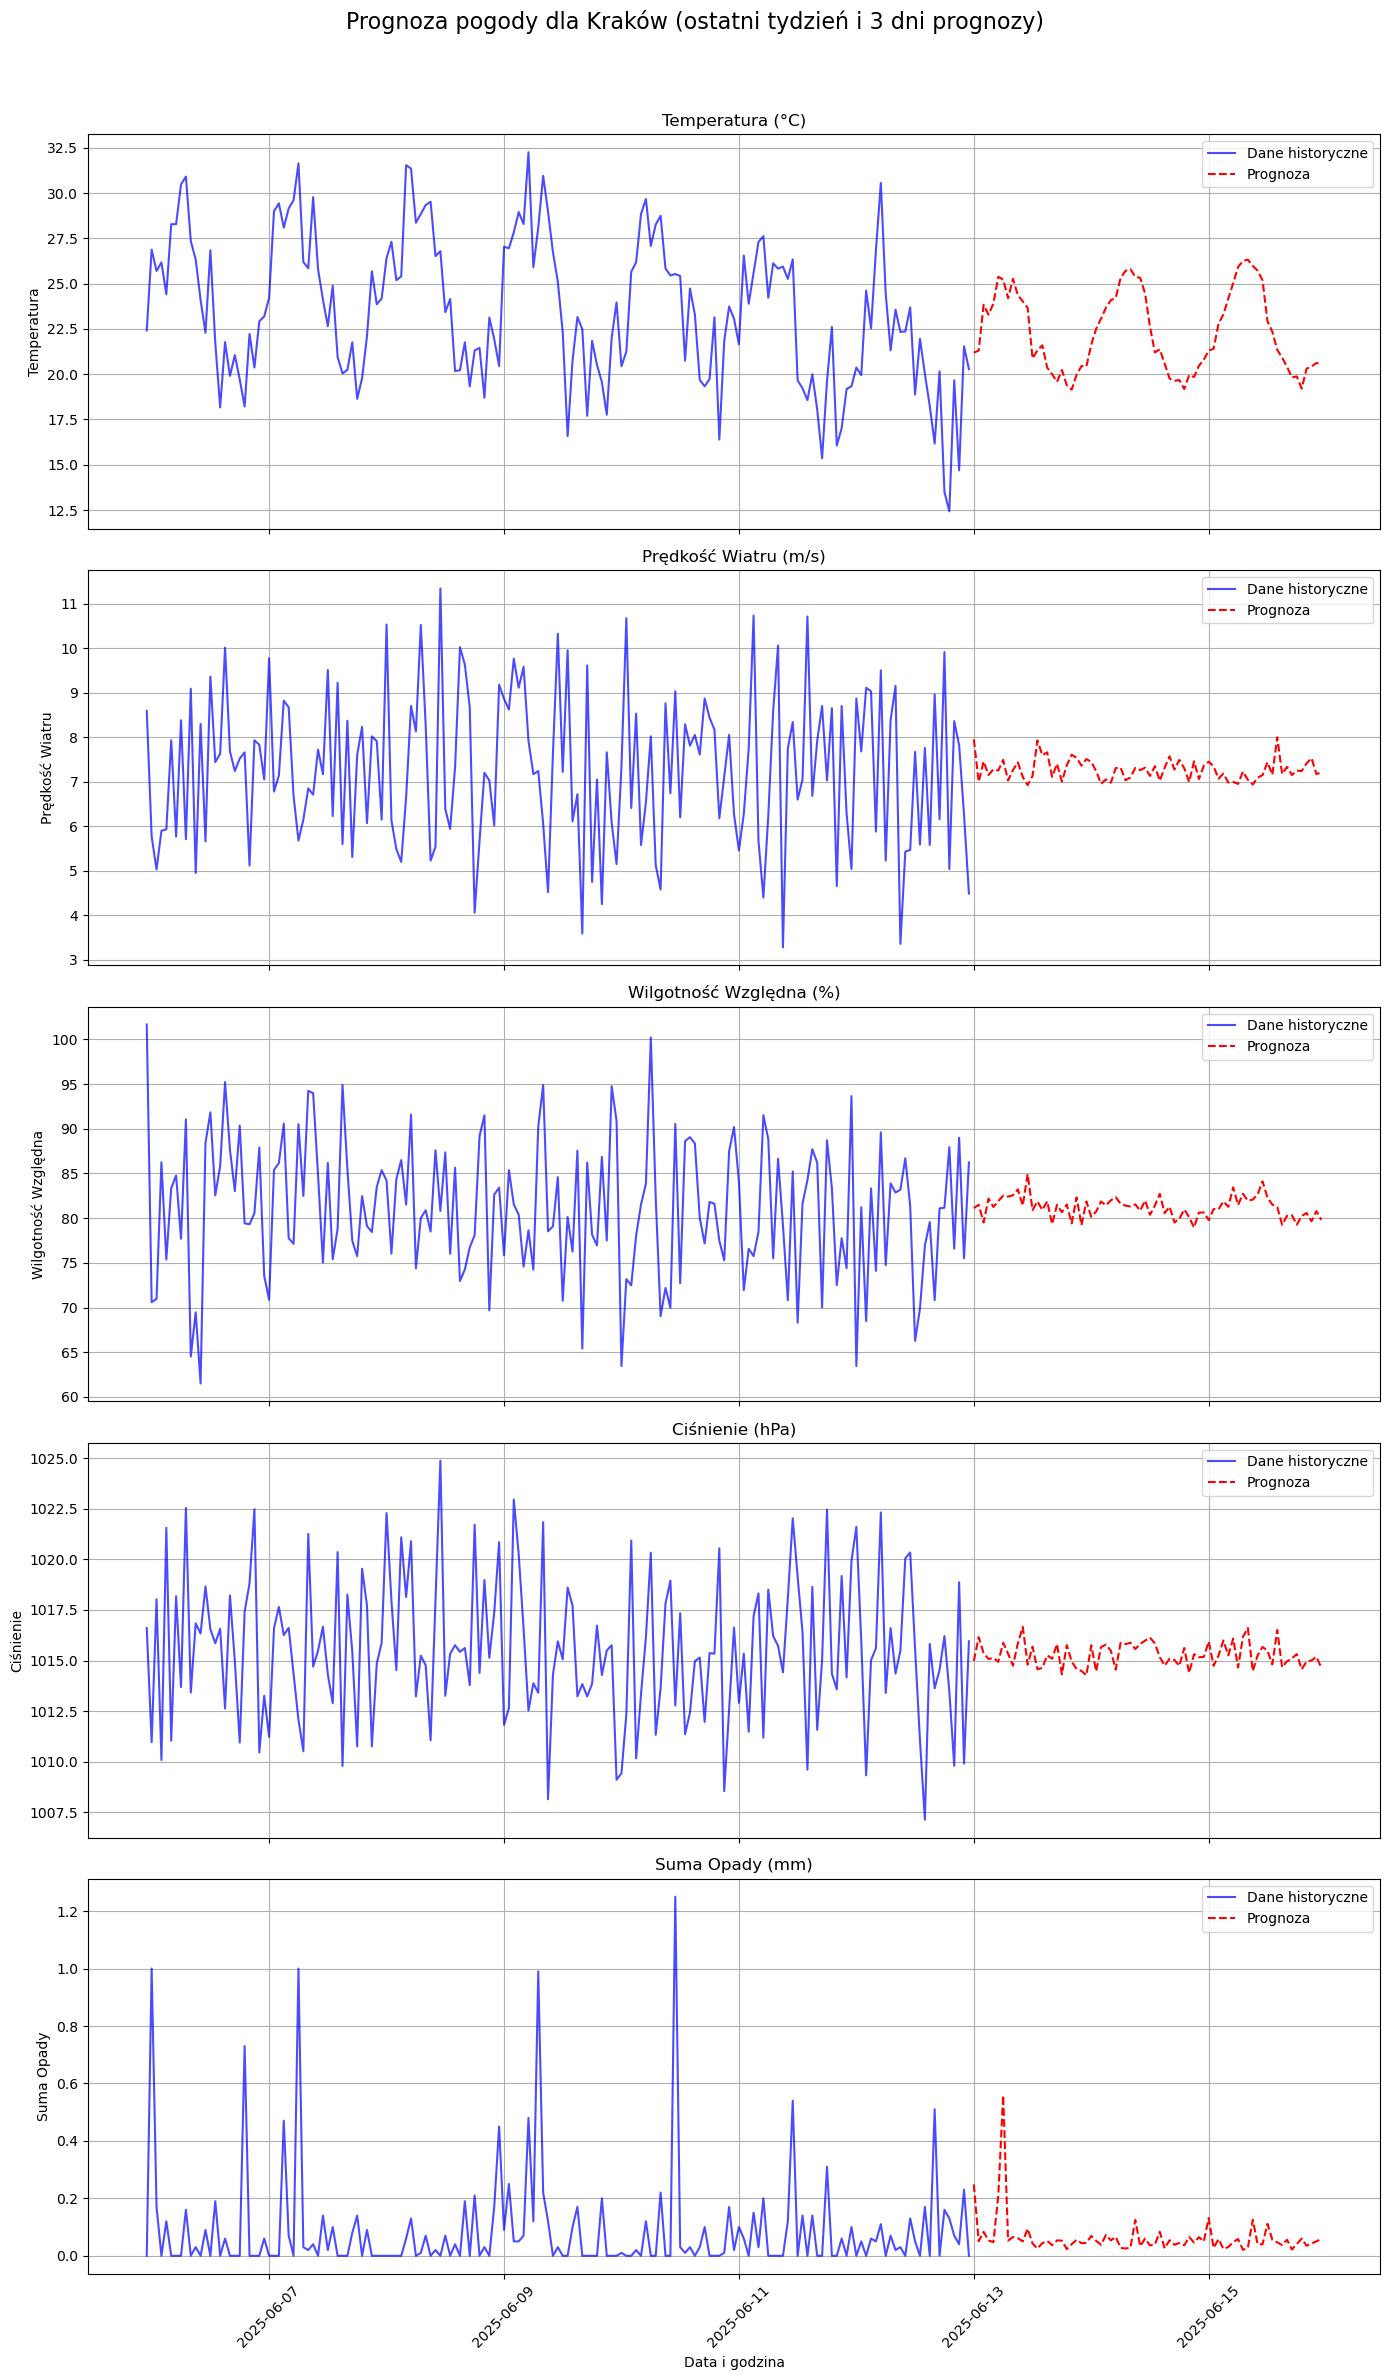


Generowanie prognozy dla: Warszawa

Prognoza pogody dla Warszawa na najbliższe 3 dni:
         Date  Hour  Temperature  Wind_Speed  Relative_Humidity   Pressure  \
0  2025-06-13     0      18.8841      7.7196            81.1788  1015.6399   
1  2025-06-13     1      22.0563      7.5955            78.2991  1015.6530   
2  2025-06-13     2      22.5900      6.7964            78.9649  1015.3200   
3  2025-06-13     3      24.4660      6.9632            82.2259  1013.3474   
4  2025-06-13     4      25.5593      6.9294            81.1630  1014.6472   

   Precipitation_Total  
0               0.1026  
1               0.0804  
2               0.0445  
3               0.0958  
4               0.0731  
...
          Date  Hour  Temperature  Wind_Speed  Relative_Humidity   Pressure  \
67  2025-06-15    19      18.7966      7.2380            82.4219  1014.5810   
68  2025-06-15    20      18.5125      7.3346            81.5429  1015.7146   
69  2025-06-15    21      18.8667      7.3620        

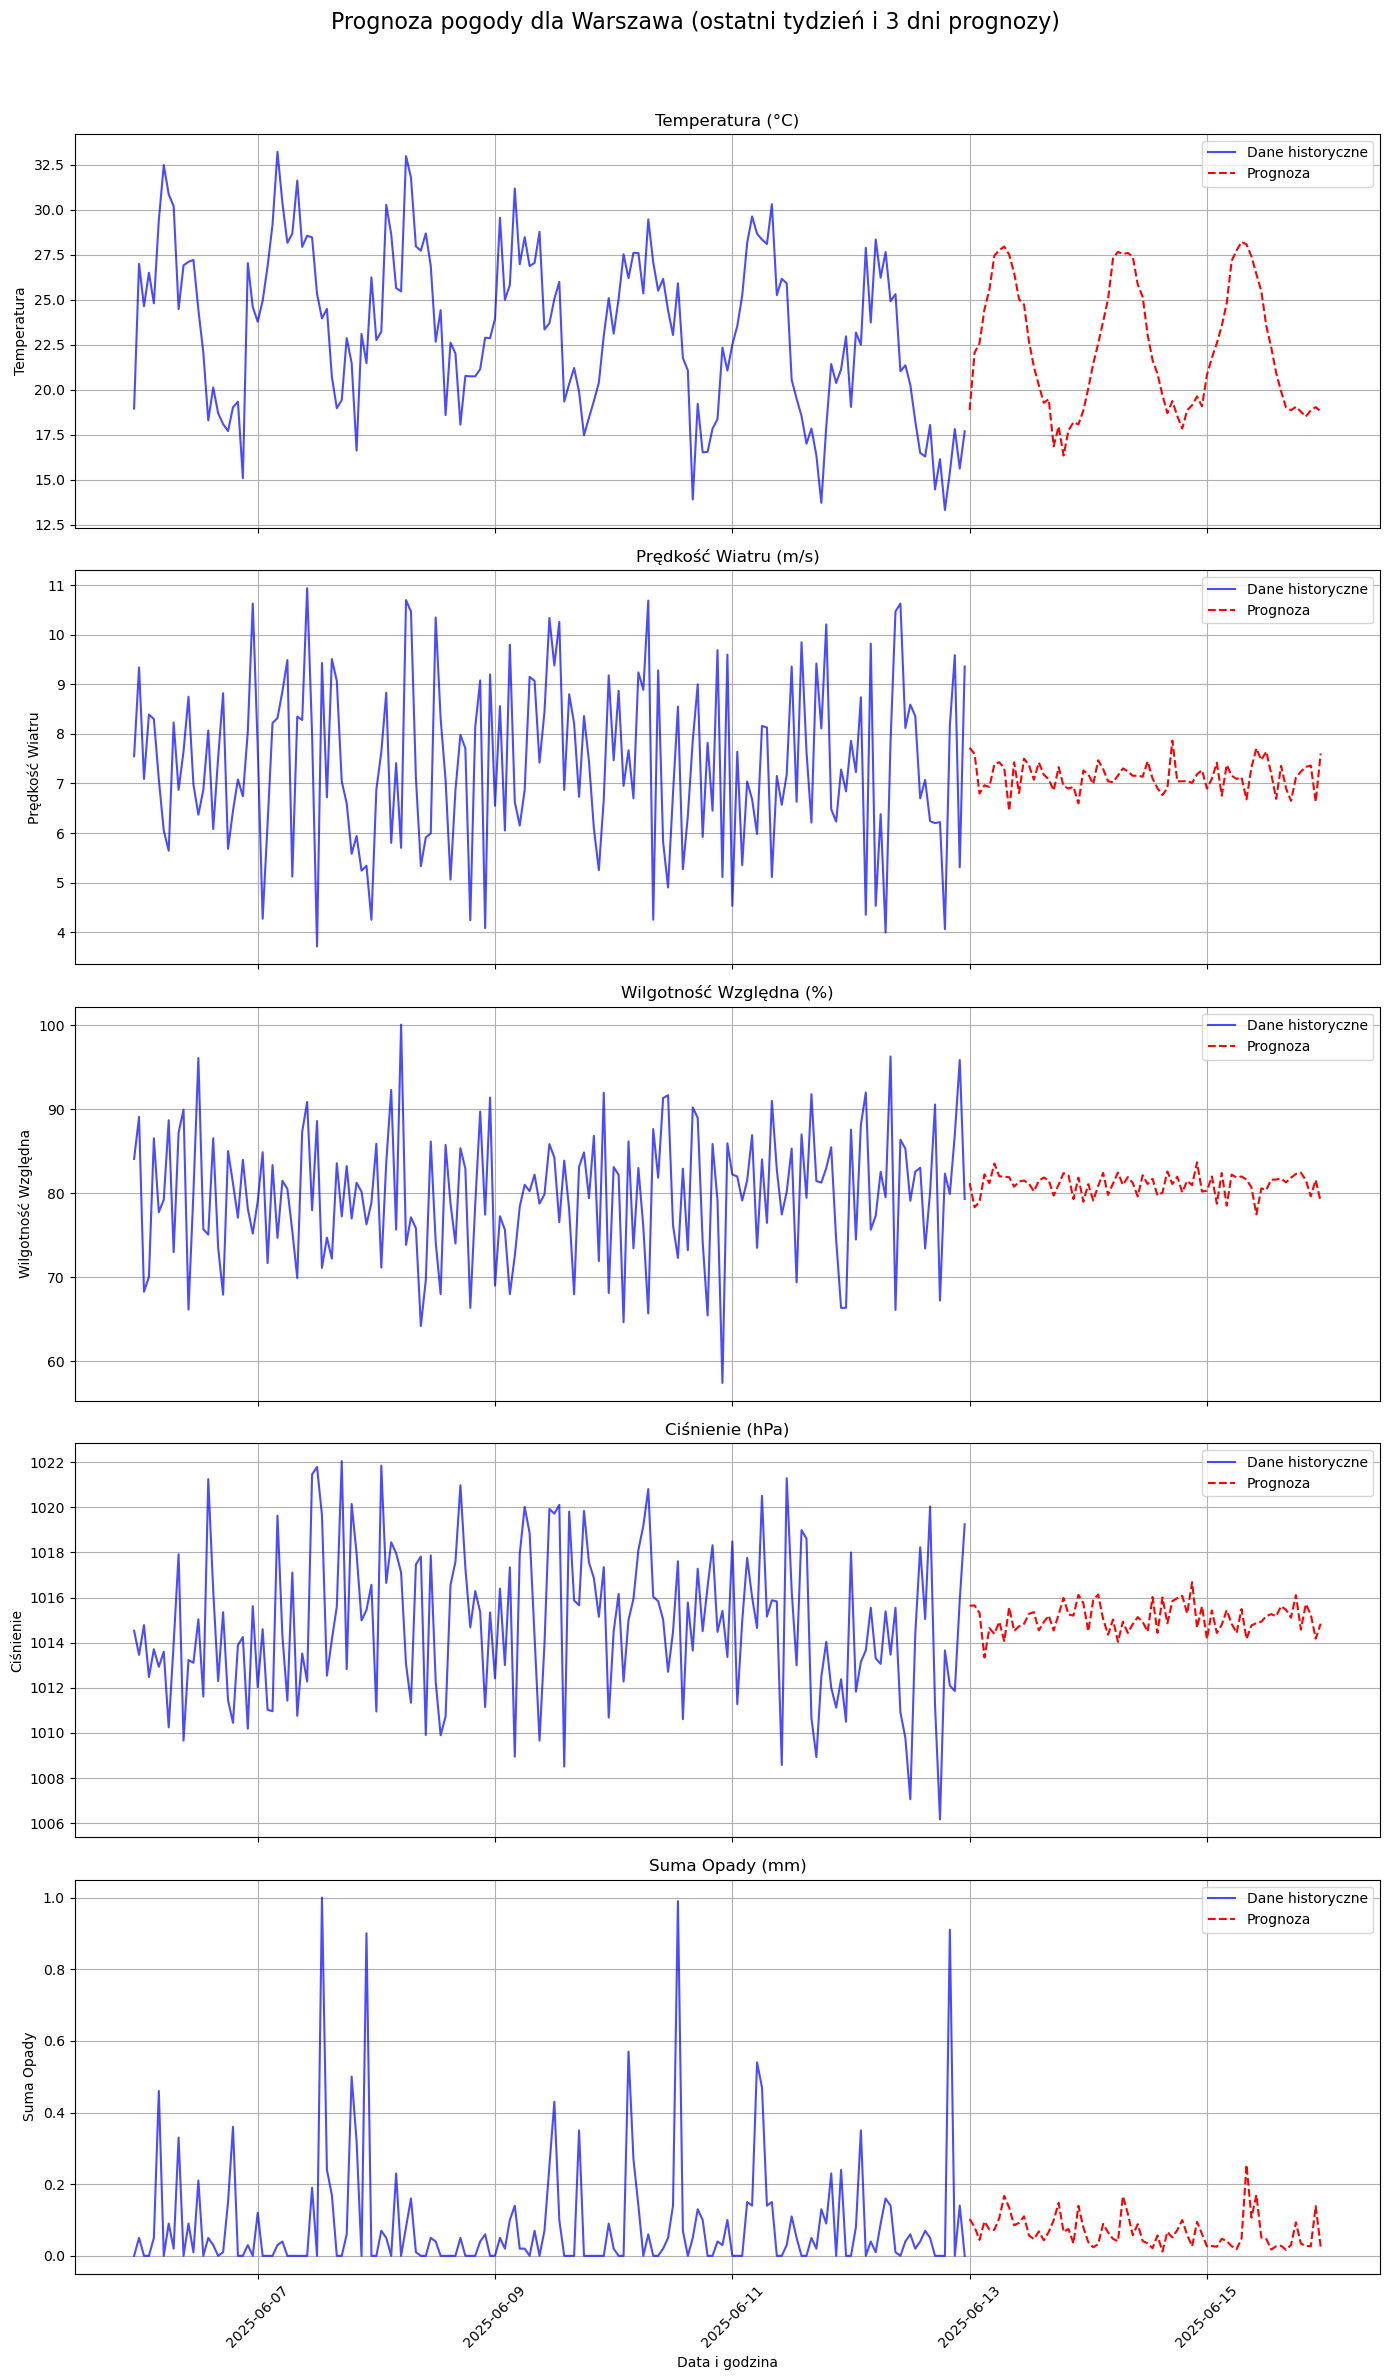


Generowanie prognozy dla: Gdańsk

Prognoza pogody dla Gdańsk na najbliższe 3 dni:
         Date  Hour  Temperature  Wind_Speed  Relative_Humidity   Pressure  \
0  2025-06-13     0      21.0100      7.7170            81.9468  1014.4341   
1  2025-06-13     1      19.0888      7.2831            80.7010  1013.7092   
2  2025-06-13     2      22.3392      6.9811            79.6956  1014.1567   
3  2025-06-13     3      23.5462      7.2053            78.9384  1014.6076   
4  2025-06-13     4      24.4268      7.3775            78.0638  1013.9848   

   Precipitation_Total  
0               0.1084  
1               0.0496  
2               0.0562  
3               0.1416  
4               0.0586  
...
          Date  Hour  Temperature  Wind_Speed  Relative_Humidity   Pressure  \
67  2025-06-15    19      18.7698      7.3176            77.7799  1014.8515   
68  2025-06-15    20      18.3768      7.4541            80.2145  1014.9043   
69  2025-06-15    21      18.2588      7.1782            

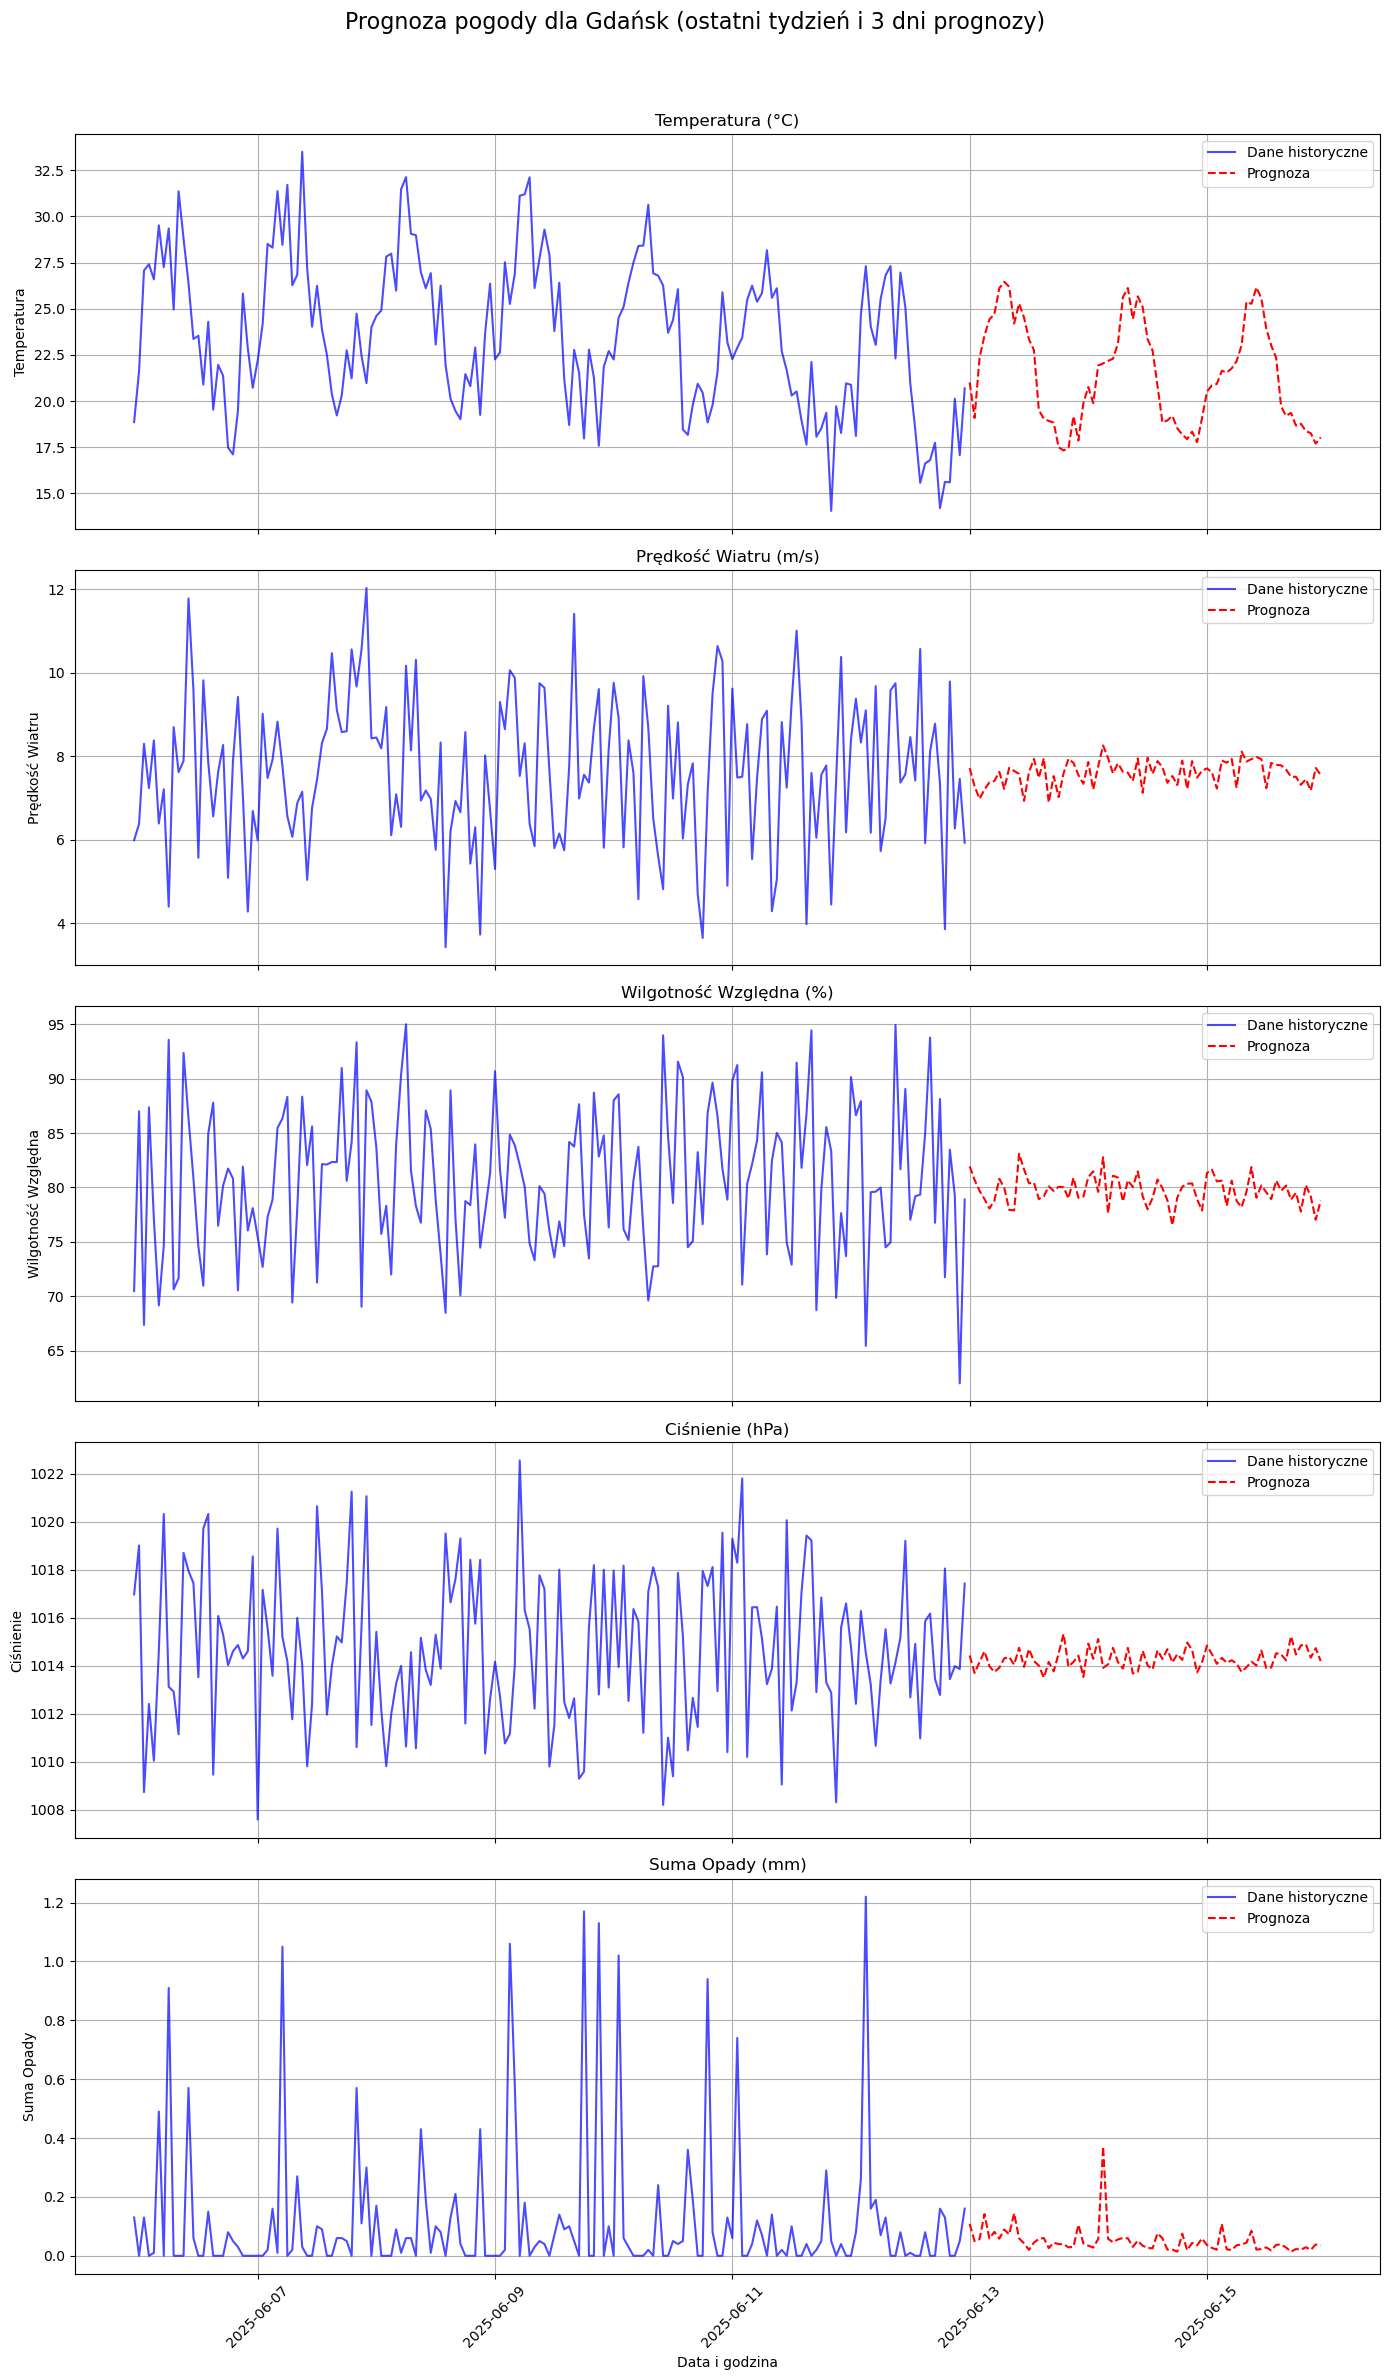


--- Prognozowanie zakończone ---


In [3]:
def create_database(db_name="weather_data"):
    """
    Tworzy lub łączy się z bazą danych SQLite i zapewnia, że obie tabele (METEO, STATIONS) istnieją.
    """
    conn = sqlite3.connect(f'{db_name}.db')
    cursor = conn.cursor()

    cursor.execute("""
        CREATE TABLE IF NOT EXISTS METEO (
            Station_Id INTEGER,
            Date TEXT,
            Hour INTEGER,
            Temperature REAL,
            Wind_Speed REAL,
            Wind_Direction INTEGER,
            Relative_Humidity REAL,
            Precipitation_Total REAL,
            Pressure REAL,
            PRIMARY KEY (Station_Id, Date, Hour)
        )
    """)
    

    cursor.execute("""
        CREATE TABLE IF NOT EXISTS STATIONS (
            Station_Id INTEGER PRIMARY KEY,
            Station_Name TEXT UNIQUE,
            Latitude REAL,
            Longitude REAL
        )
    """)
    conn.commit()

    city_coordinates = {
        'Kraków': {'lat': 50.0614, 'lon': 19.9383},
        'Warszawa': {'lat': 52.2297, 'lon': 21.0122},
        'Gdańsk': {'lat': 54.3520, 'lon': 18.6464},
        'Wrocław': {'lat': 51.1079, 'lon': 17.0305},
        'Poznań': {'lat': 52.4064, 'lon': 16.9252}
    }

    for city, coords in city_coordinates.items():
        temp_id = hash(city) % 100000 
        cursor.execute("INSERT OR IGNORE INTO STATIONS (Station_Id, Station_Name) VALUES (?, ?)", 
                       (temp_id, city)) 
        cursor.execute("UPDATE STATIONS SET Latitude = ?, Longitude = ? WHERE Station_Name = ?", 
                       (coords['lat'], coords['lon'], city))
    conn.commit() 
    
    return conn, cursor


def load_data(df, table_name, conn):
    """Ładuje DataFrame do określonej tabeli w bazie danych."""
    column_mapping = {
        'id_stacji': 'Station_Id',
        'stacja': 'Station_Name', 
        'data_pomiaru': 'Date',
        'godzina_pomiaru': 'Hour',
        'temperatura': 'Temperature',
        'predkosc_wiatru': 'Wind_Speed',
        'kierunek_wiatru': 'Wind_Direction',
        'wilgotnosc_wzgledna': 'Relative_Humidity',
        'suma_opadu': 'Precipitation_Total',
        'cisnienie': 'Pressure'
    }
    
    df_renamed = df.rename(columns=column_mapping)
    df_renamed['Station_Id'] = df_renamed['Station_Id'].astype(int)

    if 'Station_Name' in df_renamed.columns:
        df_renamed = df_renamed.drop(columns=['Station_Name'])

    df_renamed.to_sql(table_name, conn, if_exists='replace', index=False)
    print(f"Dane załadowane do tabeli {table_name}.")


def simulate_historical_data(conn, cursor, cities_to_simulate, num_days=30):
    """
    Symuluje dane historyczne dla podanych miast i ładuje je do tabeli METEO.
    Generuje dane dla ostatnich 'num_days' dni, co godzinę.
    """
    print(f"Simulating historical data for {cities_to_simulate} for {num_days} days...")
    
    station_ids = {}
    for city_name in cities_to_simulate:
        cursor.execute("SELECT Station_Id FROM STATIONS WHERE station_name = ?", (city_name,))
        result = cursor.fetchone()
        if result:
            station_ids[city_name] = result[0]
        else:
            temp_id = hash(city_name) % 100000 
            cursor.execute("INSERT OR IGNORE INTO STATIONS (Station_Id, station_name) VALUES (?, ?)", (temp_id, city_name))
            conn.commit()
            station_ids[city_name] = temp_id
            print(f"Added placeholder station ID {temp_id} for {city_name} to STATIONS (during simulation).")

    today = datetime.now()
    all_simulated_data = []

    for i in range(num_days, 0, -1): 
        current_date = today - timedelta(days=i)
        for hour in range(24):
            for city_name, station_id in station_ids.items():
                temp_base = 15 + np.sin(current_date.day / 30 * 2 * np.pi) * 10 + np.sin(hour / 24 * 2 * np.pi) * 5
                wind_base = 5 + np.random.rand() * 5
                humidity_base = 70 + np.random.rand() * 20
                pressure_base = 1010 + np.random.rand() * 10
                precip_base = np.random.choice([0, 0.1, 0.5, 1], p=[0.8, 0.1, 0.05, 0.05]) 

                simulated_row = {
                    'id_stacji': station_id,
                    'stacja': city_name, 
                    'data_pomiaru': current_date.strftime('%Y-%m-%d'),
                    'godzina_pomiaru': hour,
                    'temperatura': round(temp_base + np.random.randn() * 2, 2),
                    'predkosc_wiatru': round(wind_base + np.random.randn() * 1, 2),
                    'kierunek_wiatru': np.random.randint(0, 360),
                    'wilgotnosc_wzgledna': round(humidity_base + np.random.randn() * 5, 2),
                    'suma_opadu': round(max(0, precip_base + np.random.randn() * 0.1), 2),
                    'cisnienie': round(pressure_base + np.random.randn() * 2, 2)
                }
                all_simulated_data.append(simulated_row)
    
    df_simulated = pd.DataFrame(all_simulated_data)
    load_data(df_simulated, 'METEO', conn)
    print("Historical data simulation complete.")


def fetch_city_data(conn, city_name: str):
    """Pobiera wszystkie historyczne dane dla danej stacji z bazy METEO."""
    query = """
    SELECT 
        m.Date, 
        m.Hour, 
        m.Temperature, 
        m.Wind_Speed, 
        m.Wind_Direction, 
        m.Relative_Humidity, 
        m.Precipitation_Total, 
        m.Pressure
    FROM METEO m
    JOIN STATIONS s ON m.Station_Id = s.Station_Id
    WHERE s.station_name = ?
    ORDER BY m.Date ASC, m.Hour ASC
    """
    df = pd.read_sql_query(query, conn, params=(city_name,))
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Hour'].astype(str) + ':00:00')
    df = df.set_index('datetime').sort_index()
    return df

def prepare_forecast_data(df: pd.DataFrame, target_columns: list, lags: list):
    """
    Przygotowuje dane historyczne do prognozowania, tworząc cechy czasowe i opóźnione.
    """
    df = df[~df.index.duplicated(keep='first')]

    if not df.empty:
        full_time_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
        df = df.reindex(full_time_range)
    else:
        print("Ostrzeżenie: Pusty DataFrame w prepare_forecast_data. Nie można utworzyć cech.")
        return pd.DataFrame()

    df['hour_of_day'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['month'] = df.index.month

    for col in target_columns:
        for lag in lags:
            df[f'{col}_lag_{lag}h'] = df[col].shift(lag)
    
    df_prepared = df.dropna()

    if df_prepared.empty:
        print("Ostrzeżenie: DataFrame jest pusty po usunięciu NaN. Sprawdź zakres danych historycznych i długość lagów.")
    return df_prepared

def train_and_forecast_city(df_historical: pd.DataFrame, forecast_hours: int = 72):
    """
    Trenuje model RandomForestRegressor dla każdego parametru i prognozuje na określoną liczbę godzin.
    """
    if df_historical.empty:
        print("Brak danych historycznych do prognozowania.")
        return pd.DataFrame()

    target_columns = ['Temperature', 'Wind_Speed', 'Relative_Humidity', 'Pressure', 'Precipitation_Total'] 
    feature_columns = [col for col in df_historical.columns if '_lag_' in col or col in ['hour_of_day', 'day_of_week', 'day_of_year', 'month']]
    
    if not feature_columns:
        print("Brak kolumn cech do trenowania modelu. Sprawdź funkcję prepare_forecast_data.")
        return pd.DataFrame()

    models = {}
    for target in target_columns:
        X = df_historical[feature_columns]
        y = df_historical[target]
        
        valid_indices = y.dropna().index
        X_clean = X.loc[valid_indices]
        y_clean = y.loc[valid_indices]

        if X_clean.empty:
            print(f"Brak danych do trenowania modelu dla {target}.")
            continue

        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        model.fit(X_clean, y_clean)
        models[target] = model
    
    if not models:
        print("Nie udało się wytrenować żadnych modeli.")
        return pd.DataFrame()

    max_lag = max([1, 2, 3, 24, 48, 72]) 
    current_state_df = df_historical.iloc[-max_lag:].copy()
    
    forecast_records = []
    
    current_time = df_historical.index[-1] 

    for i in range(1, forecast_hours + 1):
        next_time = current_time + timedelta(hours=1)
        
        X_pred_dict = {}
        X_pred_dict['hour_of_day'] = next_time.hour
        X_pred_dict['day_of_week'] = next_time.dayofweek
        X_pred_dict['day_of_year'] = next_time.dayofyear
        X_pred_dict['month'] = next_time.month

        for target in target_columns: 
            for lag in [1, 2, 3, 24, 48, 72]:
                lag_col_name = f'{target}_lag_{lag}h'
                lag_time = next_time - timedelta(hours=lag)
                
        
                if lag_time in current_state_df.index:
                    X_pred_dict[lag_col_name] = current_state_df.loc[lag_time, target]
                else:
                    X_pred_dict[lag_col_name] = np.nan 

        X_pred = pd.DataFrame([X_pred_dict], columns=feature_columns)
        
        current_forecast_values = {}
        for target in target_columns:
            if target in models and not X_pred.isnull().any().any():
                predicted_value = models[target].predict(X_pred)[0]
                current_forecast_values[target] = predicted_value
            else:
                current_forecast_values[target] = np.nan 
        
        forecast_record = {
            'Date': next_time.strftime('%Y-%m-%d'),
            'Hour': next_time.hour,
            **current_forecast_values
        }
        forecast_records.append(forecast_record)
 
        new_row_df = pd.DataFrame(current_forecast_values, index=[next_time])
 
        current_state_df = pd.concat([current_state_df.iloc[1:], new_row_df])
   

        current_time = next_time 

    df_forecast = pd.DataFrame(forecast_records)
    return df_forecast


if __name__ == "__main__":
    database_name = "data"
    
    if os.path.exists(f'{database_name}.db'):
        try:
            os.remove(f'{database_name}.db')
            print(f"Removed existing {database_name}.db")
        except PermissionError:
            print(f"Warning: Could not remove {database_name}.db as it's in use. Continuing with existing database.")

    conn, cursor = create_database(database_name) 
    
 
    cities_to_forecast = ['Kraków', 'Warszawa', 'Gdańsk']
    simulate_historical_data(conn, cursor, cities_to_forecast, num_days=30) 


    conn.close() 
    conn, cursor = create_database(database_name) 

    lags_to_use = [1, 2, 3, 24, 48, 72]
    forecast_targets = ['Temperature', 'Wind_Speed', 'Relative_Humidity', 'Pressure', 'Precipitation_Total'] 

    print("\n--- Rozpoczynanie prognozowania ---")

    plot_titles = {
        'Temperature': 'Temperatura (°C)',
        'Wind_Speed': 'Prędkość Wiatru (m/s)',
        'Relative_Humidity': 'Wilgotność Względna (%)',
        'Pressure': 'Ciśnienie (hPa)',
        'Precipitation_Total': 'Suma Opady (mm)'
    }

    for city in cities_to_forecast:
        print(f"\nGenerowanie prognozy dla: {city}")
        

        historical_df = fetch_city_data(conn, city)
        
        if historical_df.empty:
            print(f"Brak danych historycznych dla {city}. Pomijam prognozowanie.")
            continue

        prepared_df = prepare_forecast_data(historical_df, forecast_targets, lags_to_use)

        if prepared_df.empty:
            print(f"Brak wystarczających danych do przygotowania cech dla {city}. Pomijam prognozowanie.")
            continue

        forecast_df = train_and_forecast_city(prepared_df, forecast_hours=72) 

        if not forecast_df.empty:
            print(f"\nPrognoza pogody dla {city} na najbliższe 3 dni:")
            print(forecast_df.head(5)) 
            print("...")
            print(forecast_df.tail(5)) 

            try:
                last_historical_dt = historical_df.index[-1]
                plot_start_dt = last_historical_dt - timedelta(days=7)

                historical_df_plot = historical_df[historical_df.index >= plot_start_dt]

                forecast_df_plot = forecast_df.copy()
                forecast_df_plot['datetime'] = pd.to_datetime(forecast_df_plot['Date'] + ' ' + forecast_df_plot['Hour'].astype(str) + ':00:00')
                forecast_df_plot = forecast_df_plot[forecast_df_plot['datetime'] >= plot_start_dt]

                fig, axes = plt.subplots(len(forecast_targets), 1, figsize=(14, 5 * len(forecast_targets)), sharex=True)
                fig.suptitle(f'Prognoza pogody dla {city} (ostatni tydzień i 3 dni prognozy)', fontsize=16)

                for i, target in enumerate(forecast_targets):
                    ax = axes[i]
                    ax.plot(historical_df_plot.index, historical_df_plot[target], label='Dane historyczne', alpha=0.7, color='blue')
                    ax.plot(forecast_df_plot['datetime'], forecast_df_plot[target], label='Prognoza', linestyle='--', color='red')
                    
                    ax.set_title(plot_titles.get(target, target)) 
                    ax.set_ylabel(plot_titles.get(target, target).split('(')[0].strip()) 
                    ax.legend()
                    ax.grid(True)
                
                plt.xlabel('Data i godzina')
                plt.xticks(rotation=45)
                plt.tight_layout(rect=[0, 0.03, 1, 0.96]) 
                plt.show()

            except Exception as e:
                print(f"Błąd podczas generowania wykresu dla {city}: {e}")
        else:
            print(f"Nie udało się wygenerować prognozy dla {city}.")

    conn.close()
    print("\n--- Prognozowanie zakończone ---")


Pogoda z uwzglednieniem wszystkiego

2025-06-13 12:46:48,949 INFO: Start pipeline
2025-06-13 12:47:25,130 INFO: Temp model: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}, score=0.336


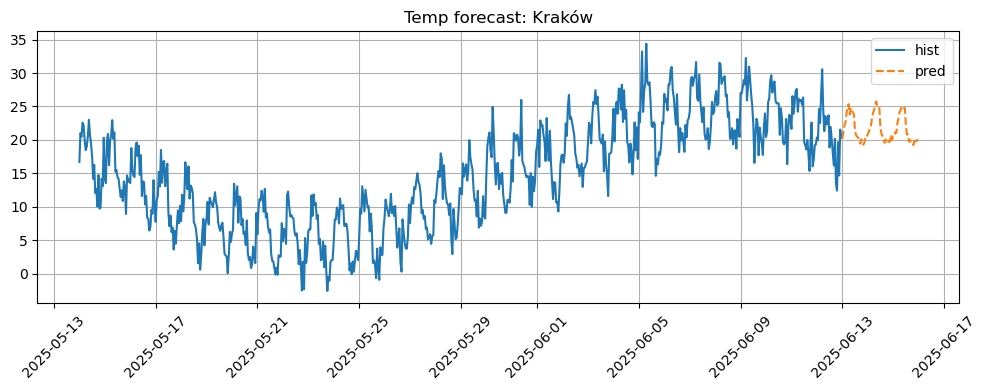

2025-06-13 12:47:59,676 INFO: Temp model: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 100}, score=0.377


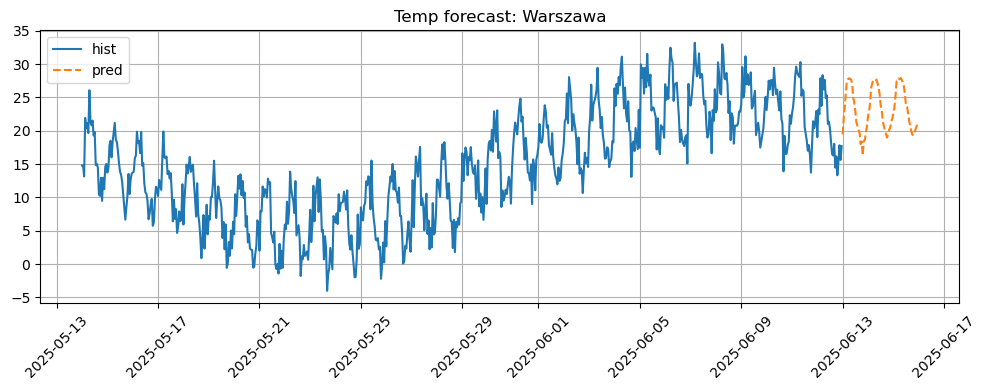

2025-06-13 12:48:32,858 INFO: Temp model: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 50}, score=0.393


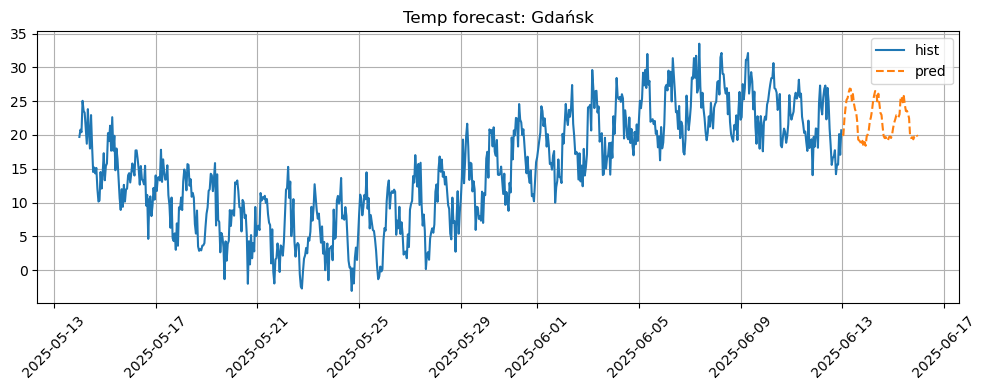

In [5]:
cfg = {
    'cities':     ['Kraków','Warszawa','Gdańsk'],
    'simulation': {'days':30},
    'lags':       [1,2,3,24,48,72],
    'forecast':   {'hours':72},
    'model':      {'rf':{'n_estimators':100,'random_state':42,'n_jobs':-1}},
    'logging':    {'level':'INFO'}
}

import logging
logging.basicConfig(
    format='%(asctime)s %(levelname)s: %(message)s',
    level=getattr(logging, cfg['logging']['level'].upper(), logging.INFO)
)
logging.info("Start pipeline")


def create_database(path="data.db"):
    conn = sqlite3.connect(path, detect_types=sqlite3.PARSE_DECLTYPES)
    cur = conn.cursor()
    cur.execute("""
      CREATE TABLE IF NOT EXISTS STATIONS(
        Station_Id INTEGER PRIMARY KEY,
        Station_Name TEXT UNIQUE, Latitude REAL, Longitude REAL
      )
    """)
    cur.execute("""
      CREATE TABLE IF NOT EXISTS METEO(
        Station_Id INTEGER, Date TEXT, Hour INTEGER,
        Temperature REAL, Wind_Speed REAL, Wind_Direction INTEGER,
        Relative_Humidity REAL, Precipitation_Total REAL, Pressure REAL,
        PRIMARY KEY(Station_Id,Date,Hour)
      )
    """)
    conn.commit()
    return conn

def upsert_meteo(df, conn):
    cols = ['Station_Id','Date','Hour','Temperature','Wind_Speed','Wind_Direction',
            'Relative_Humidity','Precipitation_Total','Pressure']
    sql = f"INSERT OR REPLACE INTO METEO({','.join(cols)}) VALUES({','.join('?'*len(cols))})"
    conn.executemany(sql, df[cols].to_records(index=False))
    conn.commit()

def load_stations(stations, conn):
    cur = conn.cursor()
    for name,(lat,lon) in stations.items():
        sid = abs(hash(name)) % 100000
        cur.execute(
          "INSERT OR IGNORE INTO STATIONS(Station_Id,Station_Name,Latitude,Longitude) VALUES(?,?,?,?)",
          (sid,name,lat,lon)
        )
    conn.commit()

def fetch_city_data(conn, city):
    sql = """
      SELECT m.*,s.Station_Name
        FROM METEO m JOIN STATIONS s USING(Station_Id)
       WHERE s.Station_Name=? ORDER BY Date,Hour
    """
    df = pd.read_sql(sql, conn, params=(city,))
    df['datetime'] = pd.to_datetime(df['Date']+' '+df['Hour'].astype(str)+':00')
    return df.set_index('datetime').sort_index()

def simulate_historical_data(conn, cities, days):
    coords = {
      'Kraków':(50.0614,19.9383),
      'Warszawa':(52.2297,21.0122),
      'Gdańsk':(54.3520,18.6464)
    }
    load_stations({c:coords.get(c,(0,0)) for c in cities}, conn)
    now = pd.Timestamp.now()
    rows=[]
    for d in range(days,0,-1):
        dt=now - pd.Timedelta(days=d)
        for h in range(24):
            for c in cities:
                base_t = 15 + np.sin(dt.day/30*2*np.pi)*10 + np.sin(h/24*2*np.pi)*5
                rows.append({
                  'Station_Id':abs(hash(c))%100000,
                  'Date':dt.strftime('%Y-%m-%d'),
                  'Hour':h,
                  'Temperature':round(base_t+np.random.randn()*2,2),
                  'Wind_Speed':round(5+np.random.rand()*5+np.random.randn(),2),
                  'Wind_Direction':int(np.random.rand()*360),
                  'Relative_Humidity':round(70+np.random.rand()*20+np.random.randn()*5,2),
                  'Precipitation_Total':round(max(0,
                      np.random.choice([0,0.1,0.5,1],p=[0.8,0.1,0.05,0.05])
                      +np.random.randn()*0.1),2),
                  'Pressure':round(1010+np.random.rand()*10+np.random.randn()*2,2)
                })
    upsert_meteo(pd.DataFrame(rows), conn)

def prepare_forecast_data(df, feat_vars, lags):
    idx = pd.date_range(df.index.min(), df.index.max(), freq='H')
    df = df.reindex(idx)
    df['hour']=df.index.hour
    df['dow']=df.index.dayofweek
    df['doy']=df.index.dayofyear
    df['month']=df.index.month
    df['sin_h']=np.sin(2*np.pi*df.hour/24)
    df['cos_h']=np.cos(2*np.pi*df.hour/24)
    for v in feat_vars:
        for lag in lags:
            df[f"{v}_lag_{lag}h"]=df[v].shift(lag)
    df = df.interpolate().ffill().bfill()
    df = df.drop(columns=['Station_Id','Date','Hour','Wind_Direction'],errors='ignore')
    return df.dropna()

def train_and_forecast_temp(df, feat_vars, target, lags, hours, rf_cfg):
    feature_cols=[c for c in df.columns if c!=target and np.issubdtype(df[c].dtype,np.number)]
    grid=GridSearchCV(
      RandomForestRegressor(**rf_cfg),
      param_grid={'n_estimators':[50,rf_cfg['n_estimators']],
                  'max_depth':[None,10,20],
                  'min_samples_leaf':[1,3]},
      cv=TimeSeriesSplit(n_splits=5), n_jobs=-1
    )
    grid.fit(df[feature_cols], df[target])
    model=grid.best_estimator_
    logging.info(f"Temp model: {grid.best_params_}, score={grid.best_score_:.3f}")

    history=df.copy()
    last=history.index.max()
    preds=[]
    for _ in range(hours):
        nxt=last+timedelta(hours=1)
        feat={
          'hour':nxt.hour,'dow':nxt.dayofweek,'doy':nxt.dayofyear,'month':nxt.month,
          'sin_h':np.sin(2*np.pi*nxt.hour/24),'cos_h':np.cos(2*np.pi*nxt.hour/24)
        }
        for v in feat_vars:
            feat[v]=history[v].get(last, history[v].iloc[-1])
            for lag in lags:
                lt=nxt-timedelta(hours=lag)
                col=f"{v}_lag_{lag}h"
                if lt in history.index:
                    feat[col]=history.loc[lt, v]
                else:
                    feat[col]=history[v].get(last, history[v].iloc[-1])

        Xp=pd.DataFrame([feat])[feature_cols]
        temp_p = model.predict(Xp)[0]
        preds.append({'Date':nxt.strftime('%Y-%m-%d'),'Hour':nxt.hour,'Temperature':temp_p})

        hist_row = {v: feat[v] for v in feat_vars}
        hist_row[target]=temp_p
        hist_df = pd.DataFrame([hist_row], index=[nxt])
        history = pd.concat([history, hist_df], axis=0) 

        last = nxt

    return pd.DataFrame(preds)

def plot_temp(df_hist, df_fc, city):
    plt.figure(figsize=(10,4))
    plt.plot(df_hist.index, df_hist['Temperature'],label='hist')
    dt = pd.to_datetime(df_fc['Date']+' '+df_fc['Hour'].astype(str)+':00')
    plt.plot(dt, df_fc['Temperature'],'--',label='pred')
    plt.title(f"Temp forecast: {city}")
    plt.legend(); plt.grid(True)
    plt.xticks(rotation=45); plt.tight_layout(); plt.show()

conn = create_database('data.db')
simulate_historical_data(conn, cfg['cities'], cfg['simulation']['days'])

for city in cfg['cities']:
    df_h = fetch_city_data(conn, city)
    feat_vars = ['Temperature','Wind_Speed','Relative_Humidity','Pressure','Precipitation_Total']
    df_feat   = prepare_forecast_data(df_h, feat_vars, cfg['lags'])
    df_pred   = train_and_forecast_temp(
                   df_feat, feat_vars, 'Temperature',
                   cfg['lags'], cfg['forecast']['hours'],
                   cfg['model']['rf']
               )
    plot_temp(df_h, df_pred, city)

conn.close()
